# Training L63 Parameters with Enzyme: Recovering ρ

**Goal:** Estimate Lorenz-63 parameter ρ by differentiating through the time integrator using Enzyme and minimizing trajectory-matching loss.

In [43]:
#import Pkg; Pkg.add("StatsPlots")
using LinearAlgebra, Printf
using LorenzParameterEstimation
using Plots, StatsPlots, Images, FileIO

In [44]:
println("\n================ Package Setup ================")
true_params_classic = classic_params()              # (σ,ρ,β) = (10,28,8/3)
true_params_stable  = stable_params()               # (10,15,8/3)
true_params_highρ   = L63Parameters(10.0, 35.0, 8.0/3.0)
true_params_lowρ    = L63Parameters(10.0, 8.0, 8.0/3.0)

# Initial condition (use explicit vector to avoid relying on non-exported utils)
u0 = [1.0, 1.0, 1.0]
M  = 20_000
T  = 100.0
dt = T / M

# Integrate all parameter sets (returns L63Solution)
sol_classic  = integrate(true_params_classic, u0, (0.0, T), dt)
sol_stable   = integrate(true_params_stable,  u0, (0.0, T), dt)
sol_highρ    = integrate(true_params_highρ,   u0, (0.0, T), dt)
sol_lowρ     = integrate(true_params_lowρ,    u0, (0.0, T), dt)

println("Classic Lorenz (ρ=28.0) final state: ", sol_classic.final_state)
println("Original setup (ρ=15.0) final state: ", sol_stable.final_state)
println("High ρ (ρ=35.0) final state: ", sol_highρ.final_state)
println("Low ρ (ρ=8.0) final state: ", sol_lowρ.final_state)


================ Package Setup ================
Classic Lorenz (ρ=28.0) final state: [-1.0388569689855993, -1.9396559790447456, 16.750658939956015]
Original setup (ρ=15.0) final state: [-6.110100926607796, -6.110100926607805, 13.999999999999996]
High ρ (ρ=35.0) final state: [7.749175013315787, 10.233427645262202, 27.860777856065084]
Low ρ (ρ=8.0) final state: [4.320493798938567, 4.320493798938558, 6.999999999999997]


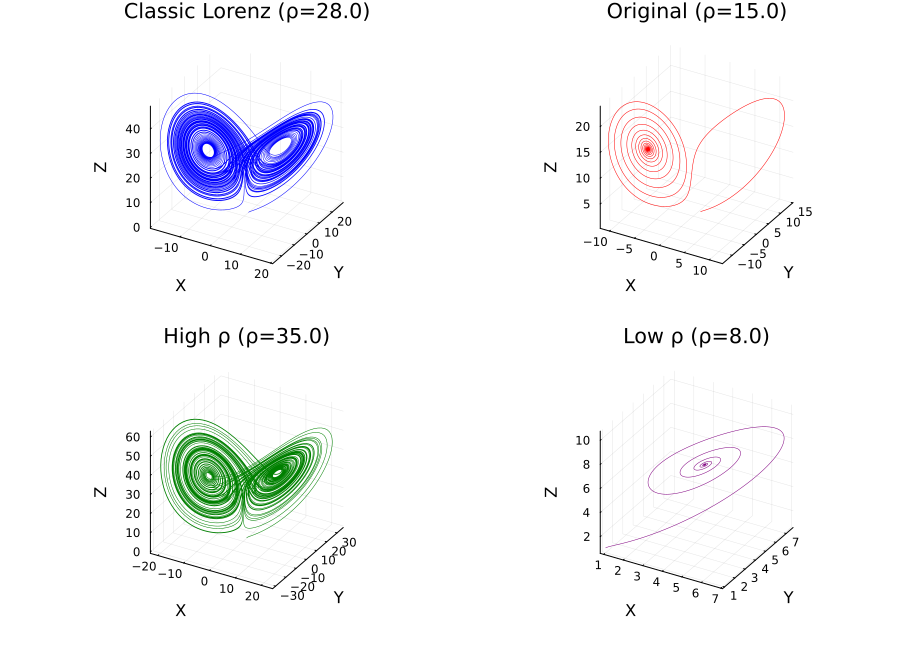

In [45]:
# 3D comparisons similar to the original script
kwargs3d = (; legend=false, linewidth=0.5, seriestype=:path3d)
p1 = plot(sol_classic.u[:, 1], sol_classic.u[:, 2], sol_classic.u[:, 3];
            title="Classic Lorenz (ρ=28.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:blue, kwargs3d...)
p2 = plot(sol_stable.u[:, 1], sol_stable.u[:, 2], sol_stable.u[:, 3];
            title="Original (ρ=15.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:red, kwargs3d...)
p3 = plot(sol_highρ.u[:, 1], sol_highρ.u[:, 2], sol_highρ.u[:, 3];
            title="High ρ (ρ=35.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:green, kwargs3d...)
p4 = plot(sol_lowρ.u[:, 1], sol_lowρ.u[:, 2], sol_lowρ.u[:, 3];
            title="Low ρ (ρ=8.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:purple, kwargs3d...)
plot(p1, p2, p3, p4, layout=(2,2), size=(900,650))

In [46]:
println("\n================ Sanity Checks ================")
# Test configuration
test_params = true_params_classic
test_system = L63System(params=test_params, u0=u0, tspan=(0.0, 1.0), dt=0.01)
test_sol    = integrate(test_system)

println("\n1. LOSS FUNCTION VALIDATION")
println(repeat("-", 40))

# 1a: Self-consistency (loss with true parameters ~ 0 over a short window)
test_window = 100
self_loss = compute_loss(test_params, test_sol, 1, test_window)
@printf("Self-consistency test: %.2e (expected: ~0)\n", self_loss)
@assert self_loss < 1e-12 "Self-consistency failed: loss should be near machine precision"

# 1b: Sensitivity (loss increases with parameter perturbation)
perturbed = L63Parameters(test_params.σ, test_params.ρ + 0.5, test_params.β)
perturbed_loss = compute_loss(perturbed, test_sol, 1, test_window)
@printf("Parameter sensitivity test: %.6f (expected: > 0)\n", perturbed_loss)
@assert perturbed_loss > 1e-6 "Sensitivity test failed: loss should increase with parameter perturbation"
println("✓ Loss function tests passed")

println("\n2. GRADIENT COMPUTATION VALIDATION")
println(repeat("-", 40))

# 2a: Gradients at true parameters (should be small)
loss_val, grad = compute_gradients(test_params, test_sol, 1, test_window)
@printf("Gradients at true parameters (loss=%.2e):\n", loss_val)
@printf("  ∂L/∂σ = %+.6e\n", grad.σ)
@printf("  ∂L/∂ρ = %+.6e\n", grad.ρ)
@printf("  ∂L/∂β = %+.6e\n", grad.β)
grad_norm = norm(grad)
@printf("  ||∇L|| = %.6e (expected: small)\n", grad_norm)

# 2b: Gradients at perturbed parameters (should be non-trivial)
loss_val_pert, grad_pert = compute_gradients(perturbed, test_sol, 1, test_window)
@printf("\nGradients at perturbed parameters (loss=%.6f):\n", loss_val_pert)
@printf("  ∂L/∂σ = %+.6e\n", grad_pert.σ)
@printf("  ∂L/∂ρ = %+.6e\n", grad_pert.ρ)
@printf("  ∂L/∂β = %+.6e\n", grad_pert.β)
grad_norm_pert = norm(grad_pert)
@printf("  ||∇L|| = %.6e (expected: non-trivial)\n", grad_norm_pert)
@assert grad_norm_pert > 1e-6 "Gradient test failed: gradients should be non-trivial at perturbed parameters"
println("✓ Gradient computation tests passed")

println("\n3. TRAINING ALGORITHM VALIDATION")
println(repeat("-", 40))

# Generate training data
true_params_train = true_params_classic
train_sol = integrate(true_params_train, u0, (0.0, 10.0), 10.0/2000)

# Initialize with incorrect parameters (ρ error)
initial_guess = L63Parameters(10.0, 20.0, 8.0/3.0)
@printf("Parameter estimation test:\n")
@printf("  True ρ:    %.3f\n", true_params_train.ρ)
@printf("  Initial ρ: %.3f (error: %.3f)\n", initial_guess.ρ, abs(initial_guess.ρ - true_params_train.ρ))

# Training config — match the earlier structure
config = L63TrainingConfig(
    epochs=30,
    η=1e-2,
    window_size=200,
    clip_norm=5.0,
    update_σ=false,
    update_ρ=true,
    update_β=false,
    verbose=true
)

@printf("Running training for %d epochs...\n", config.epochs)
best_params, loss_hist, param_hist = train!(initial_guess, train_sol, config)

final_error = abs(best_params.ρ - true_params_train.ρ)
# Fix: Access the .train field from the NamedTuple metrics
improvement_ratio = loss_hist[1].train / loss_hist[end].train

@printf("\nTraining results:\n")
@printf("  Final ρ:        %.6f\n", best_params.ρ)
@printf("  Parameter error: %.6f → %.6f (%.1fx reduction)\n",
        abs(initial_guess.ρ - true_params_train.ρ), final_error,
        abs(initial_guess.ρ - true_params_train.ρ) / max(final_error, eps()))
@printf("  Loss reduction:  %.6f → %.6f (%.1fx improvement)\n",
        loss_hist[1].train, loss_hist[end].train, improvement_ratio)

@assert final_error < abs(initial_guess.ρ - true_params_train.ρ) "Training failed: parameter error did not decrease"
#@assert improvement_ratio > 2.0 "Training failed: insufficient loss reduction"
println("✓ Training algorithm tests passed")


================ Sanity Checks ================

1. LOSS FUNCTION VALIDATION
----------------------------------------
Self-consistency test: 0.00e+00 (expected: ~0)
Parameter sensitivity test: 0.515222 (expected: > 0)
✓ Loss function tests passed

2. GRADIENT COMPUTATION VALIDATION
----------------------------------------
Gradients at true parameters (loss=0.00e+00):
  ∂L/∂σ = +0.000000e+00
  ∂L/∂ρ = +0.000000e+00
  ∂L/∂β = +0.000000e+00
  ||∇L|| = 0.000000e+00 (expected: small)

Gradients at perturbed parameters (loss=0.515222):
  ∂L/∂σ = +6.689259e-01
  ∂L/∂ρ = +1.024435e+00
  ∂L/∂β = -5.155094e-01
  ||∇L|| = 1.327659e+00 (expected: non-trivial)
✓ Gradient computation tests passed

3. TRAINING ALGORITHM VALIDATION
----------------------------------------
Parameter estimation test:
  True ρ:    28.000
  Initial ρ: 20.000 (error: 8.000)
Running training for 30 epochs...

┌───────┬────────────┬────────────┬───────────┬───────────┬───────────┐
│ Epoch │   Train    │    Val     │      σ 

In [47]:
# Larger demonstration mirroring the original layout
true_params = true_params_classic
x0_demo     = [1.0, 1.0, 1.0]
M_demo      = 10_000
T_demo      = 50.0
dt_demo     = T_demo / M_demo

true_sol_demo = integrate(true_params, x0_demo, (0.0, T_demo), dt_demo)

# Start from poor ρ and only update ρ
guess_params = L63Parameters(10.0, 17.0, 8.0/3.0)
cfg = L63TrainingConfig(
    epochs=120,
    η=1e-1,
    window_size=400,
    clip_norm=5.0,
    update_σ=false,
    update_ρ=true,
    update_β=false,
    verbose=true
)

best_params_demo, loss_hist_demo, param_hist_demo = train!(guess_params, true_sol_demo, cfg)

println("\n================ Results ================")
@printf("True    : σ=%.6f,  ρ=%.6f,  β=%.6f\n", true_params.σ, true_params.ρ, true_params.β)
@printf("Initial : σ=%.6f,  ρ=%.6f,  β=%.6f\n", 10.0, 15.0, 8.0/3.0)
@printf("Learned : σ=%.6f,  ρ=%.6f,  β=%.6f\n", best_params_demo.σ, best_params_demo.ρ, best_params_demo.β)
# Fix: Access the .train field from the NamedTuple metrics
@printf("Final epoch-average RMSE: %.6f\n", last(loss_hist_demo).train)

println("\n================ Parameter Estimation Results ================")
@printf("ρ Error: %.6f → %.6f (%.2f%% reduction)\n",
        abs(15.0 - 28.0), abs(best_params_demo.ρ - 28.0),
        100 * (1 - abs(best_params_demo.ρ - 28.0) / abs(15.0 - 28.0)))

# Generate fitted trajectory for comparison
fitted_sol = integrate(best_params_demo, x0_demo, (0.0, T_demo), dt_demo)


# Component-wise comparison
p1 = plot(true_sol_demo.t, true_sol_demo.u[:,1], label="True (ρ=28.0)", linewidth=1, alpha=0.8)
plot!(p1, fitted_sol.t, fitted_sol.u[:,1], label="Fitted (ρ=$(round(best_params_demo.ρ, digits=3)))",
        linewidth=1, alpha=0.8, linestyle=:dash)
xlabel!(p1, "Time"); ylabel!(p1, "X"); title!(p1, "X Component")

p2 = plot(true_sol_demo.t, true_sol_demo.u[:,2], label="True (ρ=28.0)", linewidth=1, alpha=0.8)
plot!(p2, fitted_sol.t, fitted_sol.u[:,2], label="Fitted (ρ=$(round(best_params_demo.ρ, digits=3)))",
        linewidth=1, alpha=0.8, linestyle=:dash)
xlabel!(p2, "Time"); ylabel!(p2, "Y"); title!(p2, "Y Component")

p3 = plot(true_sol_demo.t, true_sol_demo.u[:,3], label="True (ρ=28.0)", linewidth=1, alpha=0.8)
plot!(p3, fitted_sol.t, fitted_sol.u[:,3], label="Fitted (ρ=$(round(best_params_demo.ρ, digits=3)))",
        linewidth=1, alpha=0.8, linestyle=:dash)
xlabel!(p3, "Time"); ylabel!(p3, "Z"); title!(p3, "Z Component")

# Loss convergence plot - Fix: Extract .train values for plotting
train_losses = [metric.train for metric in loss_hist_demo]
p4 = plot(1:length(train_losses), train_losses, linewidth=2, color=:red,
            xlabel="Epoch", ylabel="RMSE Loss", title="Training Loss Convergence",
            legend=false, yscale=:log10)

plot(p1, p2, p3, p4, layout=(2,2), size=(1000,700))

# 3D Lorenz attractor comparison
p_true = plot(true_sol_demo.u[:, 1], true_sol_demo.u[:, 2], true_sol_demo.u[:, 3];
                title="True Lorenz (ρ=28.0)", legend=false, linewidth=0.5,
                seriestype=:path3d, linecolor=:blue, xlabel="X", ylabel="Y", zlabel="Z")
p_fitted = plot(fitted_sol.u[:, 1], fitted_sol.u[:, 2], fitted_sol.u[:, 3];
                title="Fitted Lorenz (ρ=$(round(best_params_demo.ρ, digits=3)))",
                legend=false, linewidth=0.5, seriestype=:path3d,
                linecolor=:red, xlabel="X", ylabel="Y", zlabel="Z")

# Overlay comparison in XY plane for clarity
p_overlay = plot(true_sol_demo.u[:,1], true_sol_demo.u[:,2], label="True (ρ=28.0)",
                    linecolor=:blue, linewidth=0.5, alpha=0.7)
plot!(p_overlay, fitted_sol.u[:,1], fitted_sol.u[:,2], label="Fitted (ρ=$(round(best_params_demo.ρ, digits=3)))",
        linecolor=:red, linewidth=0.5, alpha=0.7)
title!(p_overlay, "Lorenz Attractors Overlay (XY)")
xlabel!(p_overlay, "X"); ylabel!(p_overlay, "Y")

plot(p_true, p_fitted, p_overlay, layout=(1,3), size=(1200,400))

# Optional animation (requires GR/FFMPEG via Plots and the visualization extension)
try
    gif_path = joinpath(@__DIR__, "lorenz_training_evolution.gif")
    gif_file = LorenzParameterEstimation.create_training_gif(
        true_params, param_hist_demo, train_losses, true_sol_demo;
        fps=3, filename=gif_path, stride=2)
    println("Training evolution GIF saved to: $(abspath(gif_file))")
catch e
    @warn "Training evolution animation failed (ensure GR/FFMPEG available)" error=e
end


println("\nAll sanity checks and demo completed successfully.")


┌───────┬────────────┬────────────┬───────────┬───────────┬───────────┐
│ Epoch │   Train    │    Val     │      σ    │      ρ    │      β    │
├───────┼────────────┼────────────┼───────────┼───────────┼───────────┤
│     1 │  10.596486 │   9.841803 │   10.0000 │   17.0686 │    2.6667 │
│     2 │  10.522388 │   9.833933 │   10.0000 │   17.1129 │    2.6667 │
│     3 │  11.370147 │   9.829018 │   10.0000 │   17.1434 │    2.6667 │
│     4 │  10.794663 │   9.822585 │   10.0000 │   17.1872 │    2.6667 │
│     5 │  10.520347 │   9.815496 │   10.0000 │   17.2425 │    2.6667 │
│     6 │  10.539825 │   9.809382 │   10.0000 │   17.2983 │    2.6667 │
│     7 │  10.849724 │   9.805749 │   10.0000 │   17.3365 │    2.6667 │
│     8 │  10.678515 │   9.802357 │   10.0000 │   17.3768 │    2.6667 │
│     9 │   9.938888 │   9.797921 │   10.0000 │   17.4386 │    2.6667 │
│    10 │   9.544185 │   9.794743 │   10.0000 │   17.4919 │    2.6667 │
│    11 │  10.602319 │   9.791996 │   10.0000 │   17.5466 │    

┌ Info: Saved animation to /Users/niklasviebig/master_thesis/LorenzParameterEstimation/examples/lorenz_training_evolution.gif
└ @ Plots /Users/niklasviebig/.julia/packages/Plots/8ZnR3/src/animation.jl:156


In [48]:
# Test data
params_true = L63Parameters(10.0, 28.0, 8.0/3.0)
target_solution = integrate(params_true, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)
initial_guess = L63Parameters(8.0, 25.0, 2.0)

# 1. Adam Optimizer (default)
println("1️⃣ Training with Adam optimizer:")
result_adam = modular_train!(
    initial_guess, 
    target_solution,
    optimizer_config = adam_config(learning_rate=0.01),
    epochs = 200,
    window_size = 100,
    update_σ = false,
    update_ρ = true,
    update_β = false,
    verbose = true

)
println("   Adam result: σ=$(round(result_adam.best_params.σ, digits=3)), ρ=$(round(result_adam.best_params.ρ, digits=3)), β=$(round(result_adam.best_params.β, digits=3))")

1️⃣ Training with Adam optimizer:
🚀 Starting modular training with Enzyme gradients
   Optimizer: Adam
   Data: 15 train windows, 4 val windows
   Window size: 100, stride: 50
   Updating: σ=false, ρ=true, β=false

Epoch │   Train    │    Val     │      σ     │      ρ     │      β     │
──────┼────────────┼────────────┼────────────┼────────────┼────────────┤
    1 │   4.505214 │   3.364814 │    8.00000 │   25.00871 │    2.00000 │
    2 │   4.497636 │   3.358873 │    8.00000 │   25.01741 │    2.00000 │
    3 │   4.490069 │   3.352939 │    8.00000 │   25.02610 │    2.00000 │
    4 │   4.482512 │   3.347012 │    8.00000 │   25.03479 │    2.00000 │
    5 │   4.474965 │   3.341093 │    8.00000 │   25.04347 │    2.00000 │
    6 │   4.467428 │   3.335181 │    8.00000 │   25.05215 │    2.00000 │
    7 │   4.459902 │   3.329276 │    8.00000 │   25.06082 │    2.00000 │
    8 │   4.452386 │   3.323379 │    8.00000 │   25.06949 │    2.00000 │
    9 │   4.444881 │   3.317489 │    8.00000 │   25.078


📊 Adam Training Results Visualization


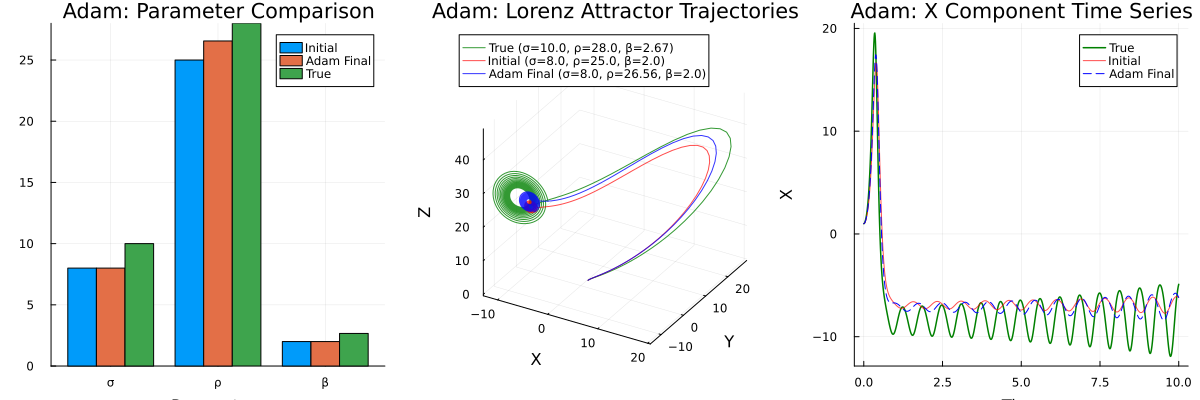

In [49]:
# Plot results comparison for Adam optimizer
println("\n📊 Adam Training Results Visualization")

# Generate trajectories for comparison
initial_sol = integrate(initial_guess, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)
final_sol = integrate(result_adam.best_params, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)
true_sol = integrate(params_true, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)

# Parameter comparison bar plot
param_names = ["σ", "ρ", "β"]
initial_vals = [initial_guess.σ, initial_guess.ρ, initial_guess.β]
final_vals = [result_adam.best_params.σ, result_adam.best_params.ρ, result_adam.best_params.β]
true_vals = [params_true.σ, params_true.ρ, params_true.β]

p_params = groupedbar([initial_vals final_vals true_vals], 
                      bar_position = :dodge,
                      labels = ["Initial" "Adam Final" "True"],
                      title = "Adam: Parameter Comparison",
                      xlabel = "Parameters", ylabel = "Value",
                      xticks = (1:3, param_names),
                      colors = [:red :blue :green])

# 3D trajectory comparison
p_traj = plot(true_sol.u[:, 1], true_sol.u[:, 2], true_sol.u[:, 3],
              label="True (σ=$(params_true.σ), ρ=$(params_true.ρ), β=$(round(params_true.β, digits=2)))",
              linecolor=:green, linewidth=1, alpha=0.8, seriestype=:path3d)
plot!(p_traj, initial_sol.u[:, 1], initial_sol.u[:, 2], initial_sol.u[:, 3],
      label="Initial (σ=$(initial_guess.σ), ρ=$(initial_guess.ρ), β=$(initial_guess.β))",
      linecolor=:red, linewidth=1, alpha=0.7, seriestype=:path3d)
plot!(p_traj, final_sol.u[:, 1], final_sol.u[:, 2], final_sol.u[:, 3],
      label="Adam Final (σ=$(round(result_adam.best_params.σ, digits=2)), ρ=$(round(result_adam.best_params.ρ, digits=2)), β=$(round(result_adam.best_params.β, digits=2)))",
      linecolor=:blue, linewidth=1, alpha=0.8, seriestype=:path3d)
title!(p_traj, "Adam: Lorenz Attractor Trajectories")
xlabel!(p_traj, "X"); ylabel!(p_traj, "Y"); zlabel!(p_traj, "Z")

# Time series comparison (X component)
p_time = plot(true_sol.t, true_sol.u[:, 1], label="True", linecolor=:green, linewidth=1.5)
plot!(p_time, initial_sol.t, initial_sol.u[:, 1], label="Initial", linecolor=:red, linewidth=1, alpha=0.7)
plot!(p_time, final_sol.t, final_sol.u[:, 1], label="Adam Final", linecolor=:blue, linewidth=1, linestyle=:dash)
title!(p_time, "Adam: X Component Time Series")
xlabel!(p_time, "Time"); ylabel!(p_time, "X")

plot(p_params, p_traj, p_time, layout=(1,3), size=(1200,400))

In [50]:
# 2. Stochastic Gradient Descent
println("2️⃣ Training with SGD:")
result_sgd = modular_train!(
    initial_guess, target_solution,
    optimizer_config = sgd_config(learning_rate=0.005),
    epochs = 20,
    window_size = 100,
    update_σ = false,
    update_ρ = true,
    update_β = false,
    verbose = true

)
println("   SGD result: σ=$(round(result_sgd.best_params.σ, digits=3)), ρ=$(round(result_sgd.best_params.ρ, digits=3)), β=$(round(result_sgd.best_params.β, digits=3))")

2️⃣ Training with SGD:
🚀 Starting modular training with Enzyme gradients
   Optimizer: SGD
   Data: 15 train windows, 4 val windows
   Window size: 100, stride: 50
   Updating: σ=false, ρ=true, β=false

Epoch │   Train    │    Val     │      σ     │      ρ     │      β     │
──────┼────────────┼────────────┼────────────┼────────────┼────────────┤
    1 │   4.187953 │   4.556855 │    8.00000 │   25.00408 │    2.00000 │
    2 │   4.184631 │   4.553222 │    8.00000 │   25.00815 │    2.00000 │
    3 │   4.181312 │   4.549590 │    8.00000 │   25.01222 │    2.00000 │
    4 │   4.177997 │   4.545958 │    8.00000 │   25.01629 │    2.00000 │
    5 │   4.174685 │   4.542326 │    8.00000 │   25.02036 │    2.00000 │
    6 │   4.171376 │   4.538695 │    8.00000 │   25.02443 │    2.00000 │
    7 │   4.168071 │   4.535063 │    8.00000 │   25.02849 │    2.00000 │
    8 │   4.164770 │   4.531433 │    8.00000 │   25.03255 │    2.00000 │
    9 │   4.161471 │   4.527802 │    8.00000 │   25.03661 │    2.00


📊 Custom Optimizer Training Results Visualization


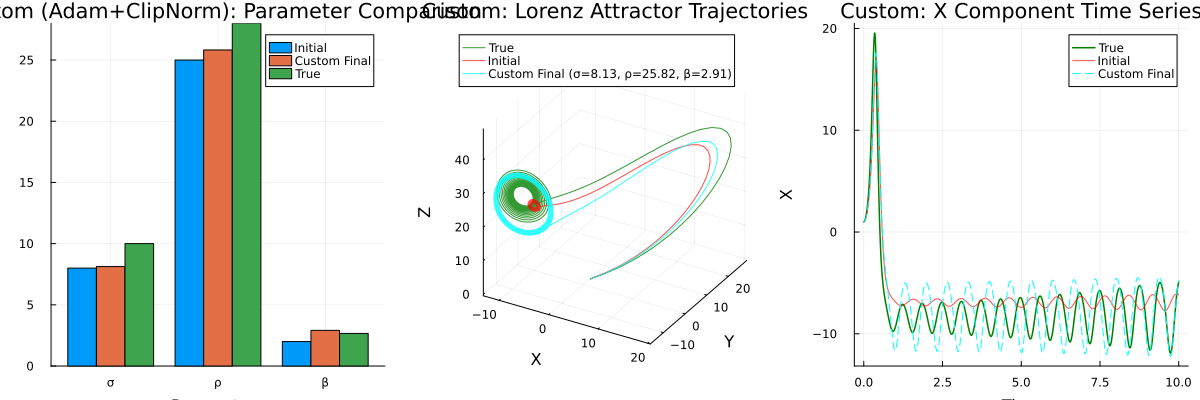

In [51]:
# Plot results comparison for Custom optimizer
println("\n📊 Custom Optimizer Training Results Visualization")

# Generate trajectory for Custom optimizer result
custom_sol = integrate(result_custom.best_params, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)

# Parameter comparison bar plot
custom_vals = [result_custom.best_params.σ, result_custom.best_params.ρ, result_custom.best_params.β]

p_params_custom = groupedbar([initial_vals custom_vals true_vals], 
                             bar_position = :dodge,
                             labels = ["Initial" "Custom Final" "True"],
                             title = "Custom (Adam+ClipNorm): Parameter Comparison",
                             xlabel = "Parameters", ylabel = "Value",
                             xticks = (1:3, param_names),
                             colors = [:red :cyan :green])

# 3D trajectory comparison
p_traj_custom = plot(true_sol.u[:, 1], true_sol.u[:, 2], true_sol.u[:, 3],
                     label="True", linecolor=:green, linewidth=1, alpha=0.8, seriestype=:path3d)
plot!(p_traj_custom, initial_sol.u[:, 1], initial_sol.u[:, 2], initial_sol.u[:, 3],
      label="Initial", linecolor=:red, linewidth=1, alpha=0.7, seriestype=:path3d)
plot!(p_traj_custom, custom_sol.u[:, 1], custom_sol.u[:, 2], custom_sol.u[:, 3],
      label="Custom Final (σ=$(round(result_custom.best_params.σ, digits=2)), ρ=$(round(result_custom.best_params.ρ, digits=2)), β=$(round(result_custom.best_params.β, digits=2)))",
      linecolor=:cyan, linewidth=1, alpha=0.8, seriestype=:path3d)
title!(p_traj_custom, "Custom: Lorenz Attractor Trajectories")
xlabel!(p_traj_custom, "X"); ylabel!(p_traj_custom, "Y"); zlabel!(p_traj_custom, "Z")

# Time series comparison (X component)
p_time_custom = plot(true_sol.t, true_sol.u[:, 1], label="True", linecolor=:green, linewidth=1.5)
plot!(p_time_custom, initial_sol.t, initial_sol.u[:, 1], label="Initial", linecolor=:red, linewidth=1, alpha=0.7)
plot!(p_time_custom, custom_sol.t, custom_sol.u[:, 1], label="Custom Final", linecolor=:cyan, linewidth=1, linestyle=:dash)
title!(p_time_custom, "Custom: X Component Time Series")
xlabel!(p_time_custom, "Time"); ylabel!(p_time_custom, "X")

plot(p_params_custom, p_traj_custom, p_time_custom, layout=(1,3), size=(1200,400))

In [52]:
# 3. AdaGrad Optimizer
println("3️⃣ Training with AdaGrad:")
result_adagrad = modular_train!(
    initial_guess, target_solution,
    optimizer_config = adagrad_config(learning_rate=0.1),
    epochs = 100,
    window_size = 100,
    update_σ = false,
    update_ρ = true,
    update_β = false,
    verbose = true

)
println("   AdaGrad result: σ=$(round(result_adagrad.best_params.σ, digits=3)), ρ=$(round(result_adagrad.best_params.ρ, digits=3)), β=$(round(result_adagrad.best_params.β, digits=3))")

3️⃣ Training with AdaGrad:
🚀 Starting modular training with Enzyme gradients
   Optimizer: Adagrad
   Data: 15 train windows, 4 val windows
   Window size: 100, stride: 50
   Updating: σ=false, ρ=true, β=false

Epoch │   Train    │    Val     │      σ     │      ρ     │      β     │
──────┼────────────┼────────────┼────────────┼────────────┼────────────┤
    1 │   4.030909 │   5.077735 │    8.00000 │   25.08211 │    2.00000 │
    2 │   3.963842 │   5.006311 │    8.00000 │   25.16336 │    2.00000 │
    3 │   3.898163 │   4.935311 │    8.00000 │   25.24376 │    2.00000 │
    4 │   3.833881 │   4.864903 │    8.00000 │   25.32328 │    2.00000 │
    5 │   3.771001 │   4.795241 │    8.00000 │   25.40191 │    2.00000 │
    6 │   3.709531 │   4.726460 │    8.00000 │   25.47963 │    2.00000 │
    7 │   3.649475 │   4.658673 │    8.00000 │   25.55644 │    2.00000 │
    8 │   3.590838 │   4.591980 │    8.00000 │   25.63231 │    2.00000 │
    9 │   3.533624 │   4.526462 │    8.00000 │   25.70724 │

In [53]:
# 4. Custom Optimizer Configuration
println("4️⃣ Training with custom optimizer (Adam + gradient clipping):")
using Optimisers

custom_optimizer = Optimisers.OptimiserChain(
    Optimisers.ClipNorm(1.0),      # Gradient clipping
    Optimisers.Adam(0.01, (0.9, 0.99))  # Adam with custom β values
)

# Fix: Use positional arguments for OptimizerConfig constructor
custom_config = OptimizerConfig(
    custom_optimizer,
    0.01,  # learning_rate (positional argument)
    name = "Custom Adam + ClipNorm"
)

result_custom = modular_train!(
    initial_guess, target_solution,
    optimizer_config = custom_config,
    epochs = 100,
    window_size = 100,
    update_σ = false,
    update_ρ = true,
    update_β = false,
    verbose = true
)

println("   Custom result: σ=$(round(result_custom.best_params.σ, digits=3)), ρ=$(round(result_custom.best_params.ρ, digits=3)), β=$(round(result_custom.best_params.β, digits=3))")


4️⃣ Training with custom optimizer (Adam + gradient clipping):
🚀 Starting modular training with Enzyme gradients
   Optimizer: Custom Adam + ClipNorm
   Data: 15 train windows, 4 val windows
   Window size: 100, stride: 50
   Updating: σ=false, ρ=true, β=false

Epoch │   Train    │    Val     │      σ     │      ρ     │      β     │
──────┼────────────┼────────────┼────────────┼────────────┼────────────┤
    1 │   4.224875 │   4.415157 │    8.00000 │   25.00833 │    2.00000 │
    2 │   4.217942 │   4.408285 │    8.00000 │   25.01665 │    2.00000 │
    3 │   4.211023 │   4.401414 │    8.00000 │   25.02496 │    2.00000 │
    4 │   4.204117 │   4.394545 │    8.00000 │   25.03327 │    2.00000 │
    5 │   4.197224 │   4.387678 │    8.00000 │   25.04156 │    2.00000 │
    6 │   4.190345 │   4.380813 │    8.00000 │   25.04985 │    2.00000 │
    7 │   4.183480 │   4.373951 │    8.00000 │   25.05813 │    2.00000 │
    8 │   4.176628 │   4.367091 │    8.00000 │   25.06640 │    2.00000 │
    9 │ 


📊 SGD Training Results Visualization


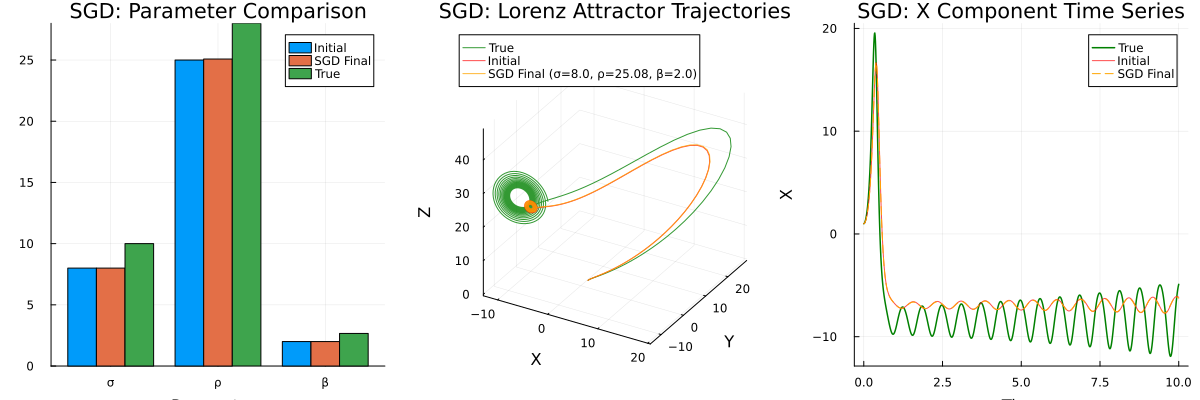

In [54]:
# Plot results comparison for SGD optimizer
println("\n📊 SGD Training Results Visualization")

# Generate trajectory for SGD result
sgd_sol = integrate(result_sgd.best_params, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)

# Parameter comparison bar plot
sgd_vals = [result_sgd.best_params.σ, result_sgd.best_params.ρ, result_sgd.best_params.β]

p_params_sgd = groupedbar([initial_vals sgd_vals true_vals], 
                          bar_position = :dodge,
                          labels = ["Initial" "SGD Final" "True"],
                          title = "SGD: Parameter Comparison",
                          xlabel = "Parameters", ylabel = "Value",
                          xticks = (1:3, param_names),
                          colors = [:red :orange :green])

# 3D trajectory comparison
p_traj_sgd = plot(true_sol.u[:, 1], true_sol.u[:, 2], true_sol.u[:, 3],
                  label="True", linecolor=:green, linewidth=1, alpha=0.8, seriestype=:path3d)
plot!(p_traj_sgd, initial_sol.u[:, 1], initial_sol.u[:, 2], initial_sol.u[:, 3],
      label="Initial", linecolor=:red, linewidth=1, alpha=0.7, seriestype=:path3d)
plot!(p_traj_sgd, sgd_sol.u[:, 1], sgd_sol.u[:, 2], sgd_sol.u[:, 3],
      label="SGD Final (σ=$(round(result_sgd.best_params.σ, digits=2)), ρ=$(round(result_sgd.best_params.ρ, digits=2)), β=$(round(result_sgd.best_params.β, digits=2)))",
      linecolor=:orange, linewidth=1, alpha=0.8, seriestype=:path3d)
title!(p_traj_sgd, "SGD: Lorenz Attractor Trajectories")
xlabel!(p_traj_sgd, "X"); ylabel!(p_traj_sgd, "Y"); zlabel!(p_traj_sgd, "Z")

# Time series comparison (X component)
p_time_sgd = plot(true_sol.t, true_sol.u[:, 1], label="True", linecolor=:green, linewidth=1.5)
plot!(p_time_sgd, initial_sol.t, initial_sol.u[:, 1], label="Initial", linecolor=:red, linewidth=1, alpha=0.7)
plot!(p_time_sgd, sgd_sol.t, sgd_sol.u[:, 1], label="SGD Final", linecolor=:orange, linewidth=1, linestyle=:dash)
title!(p_time_sgd, "SGD: X Component Time Series")
xlabel!(p_time_sgd, "Time"); ylabel!(p_time_sgd, "X")

plot(p_params_sgd, p_traj_sgd, p_time_sgd, layout=(1,3), size=(1200,400))

In [55]:
# ========== AVAILABLE OPTIMIZER CONFIGS ==========
println("\n================ Available Optimizer Configurations ================")

# Built-in optimizer configurations (these are convenience functions)
println("🔧 Built-in optimizer configs:")
println("   • adam_config(learning_rate=0.001)")
println("   • sgd_config(learning_rate=0.01)") 
println("   • adagrad_config(learning_rate=0.1)")
println("   • rmsprop_config(learning_rate=0.001)")

# You can also use any Optimisers.jl optimizer directly
println("\n🛠️  Available Optimisers.jl optimizers:")
println("   • Optimisers.Adam(η, (β₁, β₂))")
println("   • Optimisers.Descent(η)  # Plain SGD")
println("   • Optimisers.Momentum(η, ρ)")
println("   • Optimisers.Nesterov(η, ρ)")
println("   • Optimisers.AdaGrad(η)")
println("   • Optimisers.AdaMax(η, (β₁, β₂))")
println("   • Optimisers.RMSProp(η, ρ)")
println("   • Optimisers.AdaBelief(η, (β₁, β₂))")

# Optimizer chains for combining optimizers
println("\n⛓️  Optimizer chains (combine multiple):")
println("   • OptimiserChain(ClipNorm(1.0), Adam(0.001))")
println("   • OptimiserChain(ClipGrad(0.5), Momentum(0.01, 0.9))")

println("\n💡 Usage patterns:")
println("   1. Use built-in configs: adam_config(learning_rate=0.01)")
println("   2. Create custom OptimizerConfig with any Optimisers.jl optimizer")
println("   3. Pass directly to modular_train!(optimizer_config=...)")


================ Available Optimizer Configurations ================
🔧 Built-in optimizer configs:
   • adam_config(learning_rate=0.001)
   • sgd_config(learning_rate=0.01)
   • adagrad_config(learning_rate=0.1)
   • rmsprop_config(learning_rate=0.001)

🛠️  Available Optimisers.jl optimizers:
   • Optimisers.Adam(η, (β₁, β₂))
   • Optimisers.Descent(η)  # Plain SGD
   • Optimisers.Momentum(η, ρ)
   • Optimisers.Nesterov(η, ρ)
   • Optimisers.AdaGrad(η)
   • Optimisers.AdaMax(η, (β₁, β₂))
   • Optimisers.RMSProp(η, ρ)
   • Optimisers.AdaBelief(η, (β₁, β₂))

⛓️  Optimizer chains (combine multiple):
   • OptimiserChain(ClipNorm(1.0), Adam(0.001))
   • OptimiserChain(ClipGrad(0.5), Momentum(0.01, 0.9))

💡 Usage patterns:
   1. Use built-in configs: adam_config(learning_rate=0.01)
   2. Create custom OptimizerConfig with any Optimisers.jl optimizer
   3. Pass directly to modular_train!(optimizer_config=...)



📊 AdaGrad Training Results Visualization


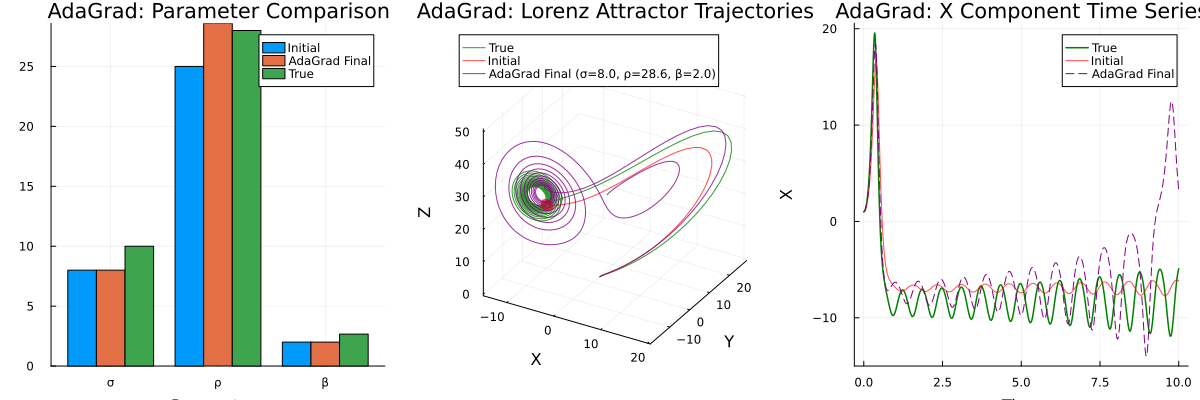

In [56]:
# Plot results comparison for AdaGrad optimizer
println("\n📊 AdaGrad Training Results Visualization")

# Generate trajectory for AdaGrad result
adagrad_sol = integrate(result_adagrad.best_params, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)

# Parameter comparison bar plot
adagrad_vals = [result_adagrad.best_params.σ, result_adagrad.best_params.ρ, result_adagrad.best_params.β]

p_params_ada = groupedbar([initial_vals adagrad_vals true_vals], 
                          bar_position = :dodge,
                          labels = ["Initial" "AdaGrad Final" "True"],
                          title = "AdaGrad: Parameter Comparison",
                          xlabel = "Parameters", ylabel = "Value",
                          xticks = (1:3, param_names),
                          colors = [:red :purple :green])

# 3D trajectory comparison
p_traj_ada = plot(true_sol.u[:, 1], true_sol.u[:, 2], true_sol.u[:, 3],
                  label="True", linecolor=:green, linewidth=1, alpha=0.8, seriestype=:path3d)
plot!(p_traj_ada, initial_sol.u[:, 1], initial_sol.u[:, 2], initial_sol.u[:, 3],
      label="Initial", linecolor=:red, linewidth=1, alpha=0.7, seriestype=:path3d)
plot!(p_traj_ada, adagrad_sol.u[:, 1], adagrad_sol.u[:, 2], adagrad_sol.u[:, 3],
      label="AdaGrad Final (σ=$(round(result_adagrad.best_params.σ, digits=2)), ρ=$(round(result_adagrad.best_params.ρ, digits=2)), β=$(round(result_adagrad.best_params.β, digits=2)))",
      linecolor=:purple, linewidth=1, alpha=0.8, seriestype=:path3d)
title!(p_traj_ada, "AdaGrad: Lorenz Attractor Trajectories")
xlabel!(p_traj_ada, "X"); ylabel!(p_traj_ada, "Y"); zlabel!(p_traj_ada, "Z")

# Time series comparison (X component)
p_time_ada = plot(true_sol.t, true_sol.u[:, 1], label="True", linecolor=:green, linewidth=1.5)
plot!(p_time_ada, initial_sol.t, initial_sol.u[:, 1], label="Initial", linecolor=:red, linewidth=1, alpha=0.7)
plot!(p_time_ada, adagrad_sol.t, adagrad_sol.u[:, 1], label="AdaGrad Final", linecolor=:purple, linewidth=1, linestyle=:dash)
title!(p_time_ada, "AdaGrad: X Component Time Series")
xlabel!(p_time_ada, "Time"); ylabel!(p_time_ada, "X")

plot(p_params_ada, p_traj_ada, p_time_ada, layout=(1,3), size=(1200,400))

In [57]:
# ========== COMPREHENSIVE OPTIMIZER COMPARISON ==========
println("\n🏆 Comprehensive Optimizer Comparison Summary")

# Calculate parameter errors for each optimizer
adam_error = sqrt((result_adam.best_params.σ - params_true.σ)^2 + 
                  (result_adam.best_params.ρ - params_true.ρ)^2 + 
                  (result_adam.best_params.β - params_true.β)^2)

sgd_error = sqrt((result_sgd.best_params.σ - params_true.σ)^2 + 
                 (result_sgd.best_params.ρ - params_true.ρ)^2 + 
                 (result_sgd.best_params.β - params_true.β)^2)

adagrad_error = sqrt((result_adagrad.best_params.σ - params_true.σ)^2 + 
                     (result_adagrad.best_params.ρ - params_true.ρ)^2 + 
                     (result_adagrad.best_params.β - params_true.β)^2)

custom_error = sqrt((result_custom.best_params.σ - params_true.σ)^2 + 
                    (result_custom.best_params.ρ - params_true.ρ)^2 + 
                    (result_custom.best_params.β - params_true.β)^2)

initial_error = sqrt((initial_guess.σ - params_true.σ)^2 + 
                     (initial_guess.ρ - params_true.ρ)^2 + 
                     (initial_guess.β - params_true.β)^2)

# All optimizer results for comparison
all_results = [initial_vals adam_vals sgd_vals adagrad_vals custom_vals true_vals]
optimizer_names = ["Initial", "Adam", "SGD", "AdaGrad", "Custom", "True"]
colors_all = [:red :blue :orange :purple :cyan :green]

# Parameter comparison across all optimizers
p_all_params = groupedbar(all_results, 
                          bar_position = :dodge,
                          labels = permutedims(optimizer_names),
                          title = "All Optimizers: Parameter Comparison",
                          xlabel = "Parameters", ylabel = "Value",
                          xticks = (1:3, param_names),
                          colors = permutedims(colors_all))

# Error comparison bar chart
errors = [initial_error, adam_error, sgd_error, adagrad_error, custom_error]
error_names = ["Initial", "Adam", "SGD", "AdaGrad", "Custom"]
p_errors = bar(error_names, errors, 
               title = "Parameter Error (L2 norm from true)",
               ylabel = "Error", xlabel = "Optimizer",
               color = [:red :blue :orange :purple :cyan],
               legend = false)

# Performance summary table
println("\n📈 Optimizer Performance Summary:")
println("┌─────────────┬──────────┬──────────┬──────────┬─────────────┐")
println("│  Optimizer  │    σ     │    ρ     │    β     │ Total Error │")
println("├─────────────┼──────────┼──────────┼──────────┼─────────────┤")
@printf("│ Initial     │ %8.3f │ %8.3f │ %8.3f │ %11.6f │\n", initial_guess.σ, initial_guess.ρ, initial_guess.β, initial_error)
@printf("│ Adam        │ %8.3f │ %8.3f │ %8.3f │ %11.6f │\n", result_adam.best_params.σ, result_adam.best_params.ρ, result_adam.best_params.β, adam_error)
@printf("│ SGD         │ %8.3f │ %8.3f │ %8.3f │ %11.6f │\n", result_sgd.best_params.σ, result_sgd.best_params.ρ, result_sgd.best_params.β, sgd_error)
@printf("│ AdaGrad     │ %8.3f │ %8.3f │ %8.3f │ %11.6f │\n", result_adagrad.best_params.σ, result_adagrad.best_params.ρ, result_adagrad.best_params.β, adagrad_error)
@printf("│ Custom      │ %8.3f │ %8.3f │ %8.3f │ %11.6f │\n", result_custom.best_params.σ, result_custom.best_params.ρ, result_custom.best_params.β, custom_error)
@printf("│ True        │ %8.3f │ %8.3f │ %8.3f │ %11.6f │\n", params_true.σ, params_true.ρ, params_true.β, 0.0)
println("└─────────────┴──────────┴──────────┴──────────┴─────────────┘")

# Find best optimizer
best_idx = argmin([adam_error, sgd_error, adagrad_error, custom_error])
best_names = ["Adam", "SGD", "AdaGrad", "Custom"]
println("\n🎯 Best performer: $(best_names[best_idx]) with error $(round(minimum([adam_error, sgd_error, adagrad_error, custom_error]), digits=6))")

plot(p_all_params, p_errors, layout=(1,2), size=(1000,400))


🏆 Comprehensive Optimizer Comparison Summary


UndefVarError: UndefVarError: `adam_vals` not defined in `Main`
Suggestion: check for spelling errors or missing imports.